# Data Science Project
______________________________________________________
In this project I will to answer the next questiong: _can you predict if a book will be a best seller?_
______________________________________________________

This project will be based on the information I will be able to gather from the "**amazon**" website, which is one of the largest e-commerce companies. They have readily available information about what they categorize as “best sellers”, and their lists, which are their most popular products based on sales, are updated hourly(according to them).

Firstly, I will install all the needed tools for this project:


In [757]:
!pip install selenium

In [2]:
pip install webdriver-manager 

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install selectorlib

Note: you may need to restart the kernel to use updated packages.


In [758]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import time

from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException
from selectorlib import Extractor
import requests
import json
import time

import sklearn

from sklearn import metrics, preprocessing, neighbors

from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline
from matplotlib.colors import ListedColormap

#plt.rcParams['figure.figsize'] = (10, 6)
#plt.style.use('ggplot')
# Create color maps
from matplotlib.colors import ListedColormap
#cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#ffff33","#4daf4a","#ff7f00"])

Those are the columns that I’ll try to find information for:

In [9]:
#columns for csv file
book_name = []
author = []
genre = []
sub_genre = []
rating_on_amazon = []
num_of_ratings_on_amazon = []
synopsis = []
publication_year = []
book_length = []
is_best_seller = []

For this project I learned to use the web-driver from the **Selenium** library, mainly because the webpages with the best-selling books have a scroll-to-infinity element to them.

I got an advice to try and run the scraping through a proxy for safety reasons, I for one wouldn’t want to get banned for this project by amazon’s bots.
So I try a free trial membership on the "**webshare**" website, but the bandwidth of the free trial was only 1G and was spent rather fast, and I learned that I have surpassed is because I stated getting errors from the driver when tried to get the to new pages.

So I abandoned it and had to start over, _not for the first time_.

In [275]:
#PROXY = '45.142.28.83:8094'
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
options.add_argument('--headless')
#options.add_argument('--proxy-server=%s' % PROXY)
driver = webdriver.Chrome(chrome_options=options)

C:\Users\youra\AppData\Local\Temp/ipykernel_13316/453096230.py:7: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(chrome_options=options)


I started with the best selling books lists, and wanted to get to the sub genres, so first my scraper crawled to get the main genre urls, and from there to the sub genres.

At first I wanted to get to the sub sub genres as far as it will go, but than I saw that I had to many, and loop I wrote didn’t have a good enough stop condition, so after **_3.5 hours_**, I interrupted the kernel and optimized the code as you see below:

In [144]:
def get_sub_genre_list(driver):
    driver.get("https://www.amazon.com/best-sellers-books-Amazon/zgbs/books/ref=zg_bs_unv_books_1_1_1") 
    page_source = driver.page_source
    
    soup = BeautifulSoup(page_source,'lxml')
    
    soup_genre_list = soup.find_all('div', {'class': '_p13n-zg-nav-tree-all_style_zg-browse-item__1rdKf _p13n-zg-nav-tree-all_style_zg-browse-height-large__1z5B8'})
    genre_url_list = []
    sub_genre_url_list = []
    final_genre_url_list = []
    
    for item in soup_genre_list: #get urls for all major genres
        try:
            genre_url_list.append("https://www.amazon.com"+item.find('a').get('href'))
        except:
            continue
    driver.implicitly_wait(2)
    soup_sub_genre_list = []
    for url in genre_url_list: #crawl to find sub genres
        driver.get(url) 
        page_source = driver.page_source
        soup = BeautifulSoup(page_source,'lxml')
        soup_group = soup.find('div', {"role":"group"}) 
        soup_sub_genre_list = soup_group.find_all('div', {"role":"treeitem"})
        #crawling to find urls for sub genres
        for item in soup_sub_genre_list:
            try:
                url = "https://www.amazon.com"+(item.find('a').get('href'))
                sub_genre_url_list.append(url)
            except:
                continue
        driver.implicitly_wait(3)
        
    return sub_genre_url_list
    

In [145]:
sub_genre_lists = get_sub_genre_list(driver)
print(len(sub_genre_lists))

609


609 sub-genres from about 34 genres, on one hand it seems impressive, on the other, I understood too late that some of the “genres” were: “books on cd”, “calendars” and even “deals in books”, which are genres of books at all. So for the non-best-sellers I have decided to do better and choose which genres to scrape. (Although I could have done it in a more elegant way, I did it manually), but first I needed to scrape and book’s urls.

In general, on Amazon best-seller lists there are 100 books, spread 50/50 across 2 webpages, and to see all the listing in the html, you need to scroll to the bottom of the books that are readily available (about 30) wait for another 10 to load, and again scroll down and wait for the last 10 to load. And to be able to do that I used selenium to imitate scrolling to the last available item.


In [222]:
def extract_book_url(driver,):
    best_seller_books_urls = []
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1
    
    while True:
            # scroll one screen height each time
            driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
            i += 1
            time.sleep(0.2)
            # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
            scroll_height = driver.execute_script("return document.body.scrollHeight;")  
            # Break the loop when the height we need to scroll to is larger than the total scroll height
            if (screen_height) * i > scroll_height:
                break     
    
    page_source = driver.page_source
    soup = BeautifulSoup(page_source,'lxml')
    soup_group = soup.find('div', {"class":"p13n-gridRow _cDEzb_grid-row_3Cywl"})
    try:
        soup_book_list = soup_group.find_all('a', {"tabindex":"-1"})
    except:
        return
    soup_book_list = soup_group.find_all('a', {"tabindex":"-1"})
    for a in soup_book_list:
        try:
            url = "https://www.amazon.com"+(a.get('href'))
            best_seller_books_urls.append(url)
        except:
            continue
    return best_seller_books_urls

In [230]:

def get_best_seller_books(driver,sub_genre_lists):
    best_seller_books_urls = []
    
    for url in sub_genre_lists: #crawl to find book urls
        driver.get(url)  

        best_seller_books_urls.extend(extract_book_url(driver))

        try:
            num_page = driver.find_element_by_class_name('a-last').click()
        except:
            continue

        best_seller_books_urls.extend(extract_book_url(driver))
        print(len(best_seller_books_urls))
        driver.implicitly_wait(1.5)
    
    return best_seller_books_urls

#scrolling from: https://medium.com/analytics-vidhya/using-python-and-selenium-to-scrape-infinite-scroll-web-pages-825d12c24ec7

In [231]:
best_seller_books_list = get_best_seller_books(driver,sub_genre_lists)

C:\Users\youra\AppData\Local\Temp/ipykernel_13316/1474211435.py:10: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  num_page = driver.find_element_by_class_name('a-last').click()


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2088
2180
2280
2368
2456
2544
2644
2744
2844
2944
3044
3144
3244
3344
3444
3544
3644
3744
3840
3940
4036
4136
4236
4336
4436
4536
4636
4716
4816
4916
5016
5116
5216
5316
5416
5516
5616
5716
5816
5904
6004
6104
6204
6304
6404
6504
6604
6692
6792
6888
6988
7088
7176
7276
7376
7476
7576
7676
7776
7876
7964
8052
8140
8240
8340
8440
8540
8640
8740
8840
8940
9040
9140
9240
9340
9440
9528
9628
9728
9828
9916
10000
10100
10231
10331
10431
10531
10631
10731
10831
10931
11031
11131
11231
11331
11431
11531
11631
11731
11831
11931
12031
12131
12231
12331
12431
12531
12631
12731
12827
12927
13027
13127
13227
13327
13427
13527
13627
13715
13803
13903
14003
14085
14181
14281
14381
14481
14581
14681
14781
14881
14981
15081
15169
15257
15357
15457
15557
15657
15745
15833
15933
16033
16133
16233
16333
16433
16533
16633
16733
16833
16933
17033
17133
17233
17333
17433
17533
17633
17733
17833
17933
18033
18133
18233


In [232]:
print(len(best_seller_books_list))

59713


And then again, 59713 book urls sounds impressive, only some of them as stated previously aren't from "real" genres and a very large number of them, unfortunately, **duplicates**.

In [234]:
best_seller_books_df = pd.DataFrame({"best sellers urls":best_seller_books_list})
best_seller_books_df

,best sellers urls
0,https://www.amazon.com/Elements-Style-Designin...
1,https://www.amazon.com/Made-Living-Collected-I...
2,https://www.amazon.com/Architectural-Digest-10...
3,https://www.amazon.com/Homebody-Guide-Creating...
4,https://www.amazon.com/New-Design-Rules-Decora...
...,...
59708,https://www.amazon.com/Camping-Journal-Logbook...
59709,https://www.amazon.com/Word-Search-Kids-Ages-6...
59710,https://www.amazon.com/Graceland-At-Last-Heart...
59711,https://www.amazon.com/DeLorme%C2%AE-Florida-A...


In [235]:
best_seller_books_df.to_csv("best_seller_books.csv")

From here I started scraping data about books that aren’t necessarily categorized best-seller, but from a general list of books that amazon provides (sorted by most reviews)

The previous scraper would have worked for these lists because the html structure for them is different, *obviously*

In [286]:
def get_sub_genre_list_2(driver):
    url_list = ["https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A2&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_2","https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A3&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_3",\
               "https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A4&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_5","https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A4366&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_7",\
               "https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A5&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_8","https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A173507&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_12",\
               "https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A10&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_13","https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A9&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_14",\
               "https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A86&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_15","https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A10777&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_16",\
               "https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A301889&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_17","https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A17&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_18",\
               "https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A173514&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_19","https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A18&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_20",\
               "https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A20&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_21","https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A3377866011&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_22",\
               "https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A22&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_24","https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A75&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_26",\
               "https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A25&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_27","https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A4736&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_28",\
               "https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A26&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_29","https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A28&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_30",\
               "https://www.amazon.com/s?i=stripbooks&bbn=1000&rh=n%3A283155%2Cn%3A23&s=review-count-rank&dc&fs=true&qid=1652982796&rnid=1000&ref=sr_nr_n_25"]
    sub_genre_url_list = []
    
    for url in url_list: #crawl to find sub genres
        driver.get(url) 
        page_source = driver.page_source
        soup = BeautifulSoup(page_source,'lxml')
        soup_sub_genre_list = soup.find_all('li', {"class":"a-spacing-micro s-navigation-indent-2"})
        #crawling to find urls for sub genres
        for item in soup_sub_genre_list:
            try:
                genre_url = "https://www.amazon.com"+(item.find('a').get('href'))
                sub_genre_url_list.append(genre_url)
            except:
                continue
        driver.implicitly_wait(2)
        
    return sub_genre_url_list
    

In [287]:
sub_genre_list_nbs = get_sub_genre_list_2(driver) #nbs = not best seller
print(len(sub_genre_list_nbs),sub_genre_list_nbs[0],sub_genre_list_nbs[len(sub_genre_list_nbs)-1])

353 https://www.amazon.com/s?i=stripbooks&bbn=2&rh=n%3A283155%2Cn%3A2%2Cn%3A2327&s=review-count-rank&dc&fs=true&qid=1652983255&rnid=2&ref=sr_nr_n_1 https://www.amazon.com/s?i=stripbooks&bbn=23&rh=n%3A283155%2Cn%3A23%2Cn%3A12036&s=review-count-rank&dc&fs=true&qid=1652983300&rnid=23&ref=sr_nr_n_28


The scraping of these books was a bit easier and faster. The is no element of infinite scrolling , and on the website itself it showed *“1-16 of over 80,000 results”* , it felt very promising.

In [288]:
def extract_book_url_nbs(driver):
    books_urls = []
    i = 1
    while True:
        page_source = driver.page_source
        soup = BeautifulSoup(page_source,'lxml')
        soup_group = soup.find('div', {"class":"s-main-slot s-result-list s-search-results sg-row"})
        try:
            soup_book_list = soup_group.find_all('div', {"class":"aok-relative"})
        except:
            return

        for item in soup_book_list:
            try:
                url = "https://www.amazon.com"+(item.find('a').get('href'))
                books_urls.append(url)
            except:
                continue

        try:
            num_page = driver.find_element_by_class_name('s-pagination-item s-pagination-next s-pagination-button s-pagination-separator').click()
        except:
            break
        i=i+1
        if i==100:
            break
        driver.implicitly_wait(2)
    
    return books_urls

In [289]:
def get_books(driver,sub_genre_lists):
    book_urls = []
    
    for url in sub_genre_lists: #crawl to find book urls
        driver.get(url)  

        try:
            book_urls.extend(extract_book_url_nbs(driver))
        except:
            continue

        print(len(book_urls))
    
    return book_urls

In [290]:
nbs_books_list = get_books(driver,sub_genre_list_nbs)

C:\Users\youra\AppData\Local\Temp/ipykernel_13316/2144584034.py:21: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  num_page = driver.find_element_by_class_name('s-pagination-item s-pagination-next s-pagination-button s-pagination-separator').click()


55
114
169
225
282
335
387
436
487
537
587
636
689
737
790
839
888
940
989
1039
1088
1139
1189
1239
1288
1336
1386
1435
1484
1534
1584
1635
1684
1734
1785
1838
1891
1945
1997
2046
2096
2148
2206
2257
2307
2361
2417
2470
2521
2570
2621
2671
2721
2774
2825
2876
2926
2980
3028
3076
3126
3176
3226
3283
3332
3381
3430
3478
3529
3578
3627
3678
3726
3774
3823
3872
3921
3970
4019
4069
4121
4169
4218
4268
4316
4364
4412
4463
4512
4561
4612
4665
4719
4768
4819
4868
4916
4967
5015
5064
5113
5162
5212
5260
5309
5357
5406
5454
5502
5553
5601
5649
5698
5752
5804
5858
5907
5962
6012
6064
6118
6173
6222
6275
6324
6372
6430
6484
6540
6591
6642
6697
6749
6799
6848
6903
6953
7002
7051
7099
7148
7196
7244
7292
7340
7388
7436
7488
7538
7588
7636
7685
7733
7781
7829
7879
7928
7980
8029
8081
8130
8181
8235
8291
8348
8404
8452
8507
8559
8610
8666
8715
8767
8816
8875
8932
8982
9038
9093
9149
9199
9247
9302
9358
9415
9468
9517
9571
9619
9671
9720
9773
9821
9871
9921
9969
10017
10074
10132
10183
10232
10281
1032

And so felt a underwhelmed when there were only 17924 books in the list, knowing there most likely will be duplicates within, and between this list and the best-seller one. 
But couldn’t optimize the code enough to get more for some reason (even with a limit of 100 pages per sub genre, which was put as a safety measure, I was sure the scraper would extract more info.

In [291]:
books_df = pd.DataFrame({"best sellers urls":nbs_books_list})
books_df.to_csv("books.csv")

I still hoped to have enough info to continue, so started to scrape the information I intended to extract, after carefully checking that the structure of the book webpage from the best-seller list and non-best-seller list were the same, and put all the safety measures for lack of info were in place.

The scraper ran for about **16 hours!**


In [374]:
def scrape_books(nbs_books_list,best_seller_books_list,driver):
    #columns for csv file
    book_name = []
    author = []
    genre = []
    sub_genre = []
    rating_on_amazon = []
    num_of_ratings_on_amazon = []
    synopsis = []
    publication_date = []
    book_length = []
    is_best_seller = []
    url_list = []
    url_list.extend(nbs_books_list)
    url_list.extend(best_seller_books_list)
    i=0
    for url in url_list:
        driver.get(url) 
        page_source = driver.page_source
        soup = BeautifulSoup(page_source,'lxml')
        try:
            book_name.append(soup.find('span', {"id":"productTitle"}).getText().strip())
        except:
            book_name.append(np.nan)
            
        try:
            author.append(soup.find('div', {"class":"a-section _about-the-author-card_carouselItemStyles_authorName__HSb1t"}).getText().strip())
        except:
            author.append(np.nan)
        
        try:
            genre.append(soup.find_all('a', {"class":"a-link-normal a-color-tertiary"})[1].getText().strip())
        except:
            genre.append(np.nan)
        
        try:
            sub_genre.append(soup.find_all('a', {"class":"a-link-normal a-color-tertiary"})[2].getText().strip())
        except:
            sub_genre.append(np.nan)
        
        try:
            rating_on_amazon.append(soup.find('span', {"class":"reviewCountTextLinkedHistogram noUnderline"}).getText().strip())
        except:
            rating_on_amazon.append(np.nan)
        
        try:
            num_of_ratings_on_amazon.append(soup.find('span', {"id":"acrCustomerReviewText"}).getText().strip())
        except:
            num_of_ratings_on_amazon.append(np.nan)
            
        try:
            synopsis.append(soup.find('div', {"aria-expanded":True}).getText().strip())
        except:
            synopsis.append(np.nan)
            
        try:
            publication_date.append(soup.find('span', {"class":"rpi-icon book_details-publication_date"}).find_parent('div').find_parent('div').find('div', {"class":"a-section a-spacing-none a-text-center rpi-attribute-value"}).getText().strip())
        except:
            publication_date.append(np.nan)
            
        try:
            book_length.append(soup.find('span', {"class":"rpi-icon book_details-fiona_pages"}).find_parent('div').find_parent('div').find('div', {"class":"a-section a-spacing-none a-text-center rpi-attribute-value"}).getText().strip())
        except:
            book_length.append(np.nan)
    
        if url in best_seller_books_list:
            is_best_seller.append(1)
        else:
            is_best_seller.append(0)
        driver.implicitly_wait(2)
        #end of loop 
        i=i+1
        if (i%100)==0:
            print(i)
            books_df_temp = pd.DataFrame({"book name":book_name,"author":author,"genre":genre,"sub genre":sub_genre,"rating on amazon":rating_on_amazon,\
                            "num of ratings on amazon":num_of_ratings_on_amazon,"synopsis":synopsis,"publication date":publication_date,\
                            "book length":book_length,"is best seller":is_best_seller})
            books_df_temp.to_csv("books_temp.csv")
        
    book_df = pd.DataFrame({"book name":book_name,"author":author,"genre":genre,"sub genre":sub_genre,"rating on amazon":rating_on_amazon,\
                            "num of ratings on amazon":num_of_ratings_on_amazon,"synopsis":synopsis,"publication date":publication_date,\
                            "book length":book_length,"is best seller":is_best_seller})
    return book_df

In [375]:
book_df = scrape_books(nbs_books_list,best_seller_books_list,driver)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

According to the number I had 77600 books! 

In [414]:
book_df.isnull().sum() 

book name                   66863
author                      77274
genre                       66866
sub genre                   66873
rating on amazon            67161
num of ratings on amazon    67161
synopsis                    66863
publication date            68864
book length                 70897
is best seller                  0
dtype: int64

Only.. the majority of them were nulls.

In [604]:
driver.quit()

But I’m not a quitter, and it was too late into the process to go back in my mind.
I started to clean the data that I gathered, which included :
* Dropping unwanted genres (from the best seller list)
* Dropping duplicate books
* Dropping books without synopsis (my whole idea was built on the text classification of the synopsis)
* Transferring values that were supposed to be numeric but weren’t to numeric values
* And re-indexing the data frame


In [729]:
import re

def clean_df(df):
    cleaned_df = df.copy()
    
    #drop unwanted genres
    cleaned_df=book_df[book_df["genre"].str.contains("Christian Books & Bibles|Travel|Reference|New, Used & Rental Textbooks|Test Preparation|Kindle eBooks|Calendars|Children's Audiobooks") == False]
    
    #drop duplicate rows
    cleaned_df.drop_duplicates(subset=["book name"],inplace=True)
    
    #drop books that don't have a synopsis or name
    cleaned_df=cleaned_df[cleaned_df["book name"].notna()]
    cleaned_df=cleaned_df[cleaned_df["synopsis"].notna()]
    print(cleaned_df.shape)
    
    #turn "rating on amazon","num of ratings on amazon" and "book length" to numeric values
    rating_on_amazon =[]
    for rating in cleaned_df["rating on amazon"]:
        if isinstance(rating, str):
            m=re.search("\d+\.\d+", rating)
            if(m):
                rating_on_amazon.append(float(m.group(0)))
            else:
                rating_on_amazon.append(np.nan)
        else:
            rating_on_amazon.append(np.nan)
    
    num_of_rating_on_amazon =[]
    for n_rating in cleaned_df["num of ratings on amazon"]:
        if isinstance(n_rating, str):
            m=re.search("\d+,\d+", n_rating)
            if(m):
                num_of_rating_on_amazon.append(float(m.group(0).replace(',','')))
            else:
                num_of_rating_on_amazon.append(np.nan)
        else:
            num_of_rating_on_amazon.append(np.nan)
            
    book_length =[]
    for n_pages in cleaned_df["book length"]:
        if isinstance(n_pages, str):
            m=re.search("\d+", n_pages)
            if(m):
                book_length.append(float(m.group(0)))
            else:
                book_length.append(np.nan)
        else:
            book_length.append(np.nan)
        
    cleaned_df.drop(["rating on amazon","num of ratings on amazon","book length"],axis=1,inplace=True)
    cleaned_df["rating on amazon"] = rating_on_amazon
    cleaned_df["num of ratings on amazon"] = num_of_rating_on_amazon
    cleaned_df["book length"] = book_length
    
    cleaned_df.index = range(len(cleaned_df.index))
    
    return cleaned_df

In [730]:
clean_book_df = clean_df(book_df)

(5693, 10)


And so, after all I had I bit more than -50k data point **after cleaning!**

In [731]:
clean_book_df

,book name,author,genre,sub genre,synopsis,publication date,is best seller,rating on amazon,num of ratings on amazon,book length
0,The 5 Love Languages: The Secret to Love that ...,Gary Chapman,Self-Help,Relationships,Over 20 million copies sold! A perennial New Y...,"January 1, 2015",0,4.8,64469.0,208.0
1,Greenlights,Matthew McConaughey,Biographies & Memoirs,Arts & Literature,#1 NEW YORK TIMES BESTSELLER • Discover the li...,"October 20, 2020",0,4.7,53887.0,304.0
2,Born a Crime: Stories from a South African Chi...,Trevor Noah,Biographies & Memoirs,Arts & Literature,#1 NEW YORK TIMES BESTSELLER • More than one m...,"February 12, 2019",0,4.8,43755.0,304.0
3,This Is Going to Hurt [TV Tie-in]: Secret Diar...,Adam Kay,Biographies & Memoirs,Arts & Literature,Soon to be an AMC+ series starring Ben Whishaw...,"May 24, 2022",0,4.6,35893.0,288.0
4,Malibu Rising: The new novel from the bestsell...,Taylor Jenkins Reid,Literature & Fiction,Genre Fiction,The new Sunday Times bestseller from the autho...,"May 27, 2021",0,4.2,35415.0,NaN
...,...,...,...,...,...,...,...,...,...,...
5688,The Memory of an Elephant,NaN,Literature & Fiction,Genre Fiction,"""The Memory of an Elephant"" is an epic saga to...","July 5, 2021",1,4.7,1047.0,221.0
5689,"One Man's Wilderness, 50th Anniversary Edition...",NaN,"Crafts, Hobbies & Home",Home Improvement & Design,Winner of the National Outdoor Book Award.Cele...,"September 11, 2018",1,4.9,1235.0,272.0
5690,The Adventures of the Mountain Men: True Tales...,NaN,History,Americas,Experience the true “great outdoors” through t...,NaN,1,4.0,NaN,NaN
5691,"Midwest Medicinal Plants: Identify, Harvest, a...",NaN,"Health, Fitness & Dieting",Alternative Medicine,"“This comprehensive, accessible, full-color gu...","June 28, 2017",1,4.8,NaN,312.0


In [556]:
clean_book_df.isnull().sum()

book name                      0
author                      5437
genre                          0
sub genre                      2
synopsis                       0
publication date            1098
is best seller                 0
rating on amazon             176
num of ratings on amazon    2517
book length                 1491
dtype: int64

In [557]:
print(type(clean_book_df["book length"][0]))

<class 'numpy.float64'>


In [558]:
clean_book_df["is best seller"].value_counts()

1    4165
0    1528
Name: is best seller, dtype: int64

The only downside was that the ratio of the best-sellers and non-best-seller wasn’t as balanced 

In [559]:
clean_book_df.describe(include="all")

,book name,author,genre,sub genre,synopsis,publication date,is best seller,rating on amazon,num of ratings on amazon,book length
count,5693,256,5693,5691,5693,4595,5693.000000,5517.000000,3176.000000,4202.000000
unique,5693,213,34,304,5582,2092,NaN,NaN,NaN,NaN
top,The 5 Love Languages: The Secret to Love that ...,Napoleon Hill,Children's Books,Literature & Fiction,"Customer Reviews, including Product Star Ratin...","May 17, 2022",NaN,NaN,NaN,NaN
freq,1,6,519,226,53,41,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,0.731600,4.630451,10027.462217,274.808425
std,NaN,NaN,NaN,NaN,NaN,NaN,0.443166,0.254874,15220.182345,272.601291
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1001.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,4.500000,2170.750000,136.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,4.700000,4456.500000,240.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,4.800000,11025.000000,352.000000


In [560]:
clean_book_df.to_csv("books_final.csv")

In [752]:
clean_book_df.corr(method="pearson")

,is best seller,rating on amazon,num of ratings on amazon,book length
is best seller,1.000000,0.007629,-0.313718,-0.092235
rating on amazon,0.007629,1.000000,0.012641,0.060499
num of ratings on amazon,-0.313718,0.012641,1.000000,0.141817
book length,-0.092235,0.060499,0.141817,1.000000


There wasn’t a clear correlation between the numeric values

<AxesSubplot:xlabel='rating on amazon'>

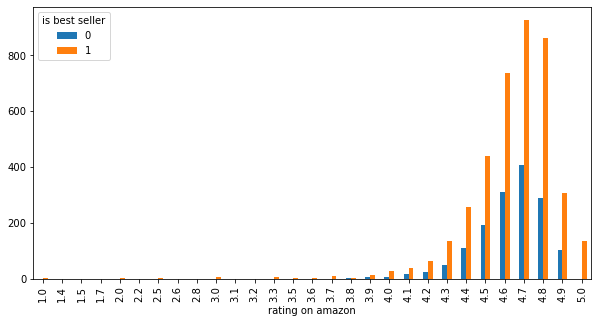

In [764]:
ct1 = pd.crosstab(clean_book_df["rating on amazon"],clean_book_df["is best seller"])
ct1.plot(kind="bar",figsize=(10,5))

What I learn from this information, is that books with more reviews, seem to have higher ratings, sometimes even more that the outliers of the best-sellers.

In [791]:
from sklearn.feature_extraction.text import CountVectorizer
from os import path
from PIL import Image
from wordcloud import WordCloud

only_best_df = clean_book_df[clean_book_df["is best seller"]==1]

best_seller_text = ""

for synopsis in only_best_df["synopsis"]:
    best_seller_text = whole_text+synopsis
whole_text.replace("NEW YORK TIMES BESTSELLER","NewYorkBestSeller")
whole_text.replace("New York","New-York")
only_best_df["is best seller"].value_counts()

1    4165
Name: is best seller, dtype: int64

In [794]:
def transform_format(val):
    if val != 0:
        return 255
    else:
        return val

image_file = Image.open("book.jpg") 
image_file = image_file.convert("1")
book_mask = np.array(image_file)

transformed_book_mask = np.ndarray((book_mask.shape[0],book_mask.shape[1]), np.int32)
for i in range(len(book_mask)):
    transformed_book_mask[i] = list(map(transform_format, book_mask[i]))

transformed_book_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

<Figure size 432x288 with 0 Axes>

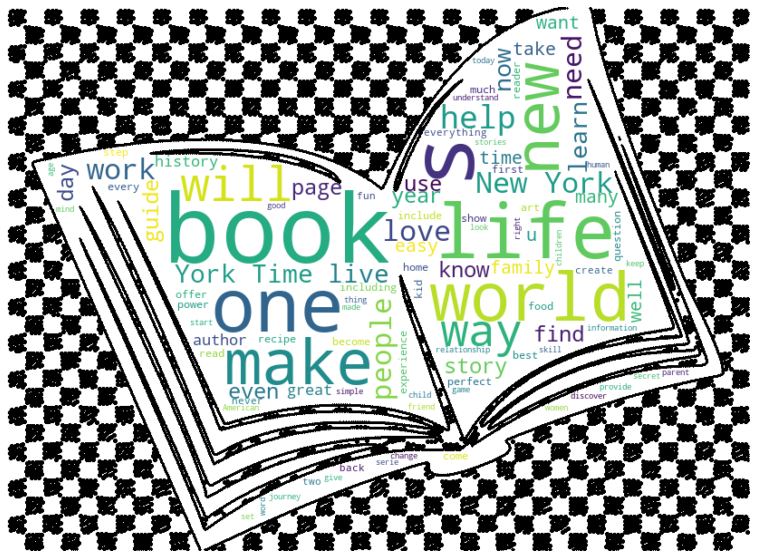

In [795]:

wordcloud = WordCloud(max_words=100,background_color="white",mask=transformed_book_mask,contour_width=3,contour_color="black").generate(best_seller_text)
wordcloud.to_file("new book.jpg")
plt.figure()
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

From the whole text is seems, that the most common words are ones that might promise to improve your live, or in general, surrounding positive topics

In [799]:
sff_df = clean_book_df[clean_book_df["genre"].str.contains("Science Fiction & Fantasy")==True]

sff_text = ""

for synopsis in sff_df["synopsis"]:
    sff_text = sff_text+synopsis
sff_text.replace("NEW YORK TIMES BESTSELLER","NewYorkBestSeller")
sff_text.replace("New York","New-York")
sff_df["genre"].value_counts()

Science Fiction & Fantasy    47
Name: genre, dtype: int64

<Figure size 432x288 with 0 Axes>

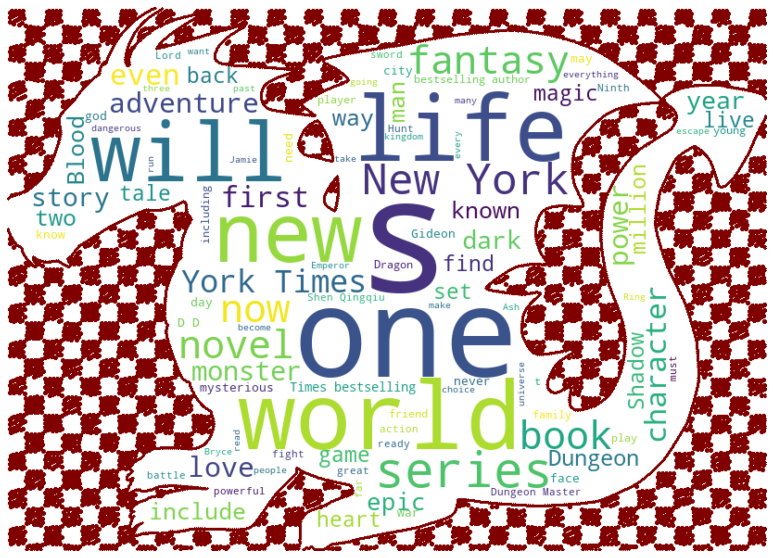

In [800]:
image_file = Image.open("dragon.jpg") 
image_file = image_file.convert("1")
dragon_mask = np.array(image_file)

transformed_dragon_mask = np.ndarray((dragon_mask.shape[0],dragon_mask.shape[1]), np.int32)
for i in range(len(dragon_mask)):
    transformed_dragon_mask[i] = list(map(transform_format, dragon_mask[i]))

wordcloud = WordCloud(max_words=100,background_color="white",mask=transformed_dragon_mask,contour_width=3,contour_color="maroon").generate(sff_text)
wordcloud.to_file("dragon.jpg")
plt.figure()
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


And of course I had to check my favorite genre 

Now it’s time to see if you can actually predict if a book is going to be best selling according to it’s synopsis.

First we will split the data to train and test data sets, when the target is to predict if a book is a best-seller (1) or not (0)


In [732]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(clean_book_df.drop(["is best seller"],axis=1), clean_book_df["is best seller"], test_size=0.33, random_state=42)


In [733]:
X_train.shape

(3814, 9)

In [746]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf_nb = Pipeline([
    ("vect",CountVectorizer(stop_words="english",min_df=5,max_features=500,analyzer="word")),
    ('norm',preprocessing.Normalizer(norm="l1")),
    ("clf", MultinomialNB()),
])
text_clf_nb.fit(X_train["synopsis"],y_train)
predicted = text_clf_nb.predict(X_test["synopsis"])
np.mean(predicted == y_test)

0.7099521021820117

The first model was based on Naive Bayes classifier, with MultinomialNB as you can see.

Which succeeded with 70% success rate, which is not that bad!

Now let’s try the Linear classifiers (SVM) with SGD training, SGDClassifier:

In [805]:
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([
    ("vect",CountVectorizer(stop_words="english",min_df=5,max_features=500,analyzer="word")),
    ('norm',preprocessing.Normalizer(norm="l1")),
        ("clf", SGDClassifier(loss='hinge')),
])
text_clf_svm.fit(X_train["synopsis"],y_train)
predicted = text_clf_svm.predict(X_test["synopsis"])
np.mean(predicted == y_test)

0.7174028738690793

It’s better but not by a large margin, unfortunately, even after playing with the parameter there wasn’t a change in the % success rate

In [806]:
print(metrics.classification_report(y_test,predicted,target_names=["not best seller","best seller"]))

                 precision    recall  f1-score   support

not best seller       0.79      0.03      0.07       545
    best seller       0.72      1.00      0.83      1334

       accuracy                           0.72      1879
      macro avg       0.75      0.52      0.45      1879
   weighted avg       0.74      0.72      0.61      1879



In [809]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(text_clf_svm, X_train["synopsis"], y_train, cv=10)
print(scores,scores.mean() )

[0.7565445  0.7565445  0.7617801  0.7565445  0.7480315  0.74540682
 0.74540682 0.75065617 0.75590551 0.74540682] 0.7522227260859409


All in all, after some cross validation, we were able to perfect the model up to 75% success rate!

I would say that it is very much possible to predict if a book is going to be a best seller based on the synopsis alone.
Of course in this project I haven’t taken into account the popularity of certain authors, the pressure of publishers’ marketing teams and prices so the conclusion should be taken with a grain of salt.


In [821]:
fiction_df = clean_book_df[clean_book_df["genre"].str.contains("Science Fiction & Fantasy|Literature & Fiction|Humor & Entertainment|Mystery, Thriller & Suspense|Romance")==True]

X_train, X_test, y_train, y_test = train_test_split(fiction_df.drop(["is best seller"],axis=1), fiction_df["is best seller"], test_size=0.33, random_state=42)

text_clf_svm = Pipeline([
    ("vect",CountVectorizer(stop_words="english",min_df=3,max_features=100,analyzer="word")),
    ('norm',preprocessing.Normalizer(norm="l1")),
        ("clf", SGDClassifier(loss='hinge')),
])

text_clf_svm.fit(X_train["synopsis"],y_train)
predicted = text_clf_svm.predict(X_test["synopsis"])
np.mean(predicted == y_test)

0.6544715447154471

In [822]:
scores = cross_val_score(text_clf_svm, X_train["synopsis"], y_train, cv=10)
print(scores,scores.mean() )

[0.6        0.68       0.58       0.62       0.58       0.62
 0.7        0.68       0.57142857 0.67346939] 0.6304897959183673


In [823]:
fiction_df["is best seller"].value_counts()

1    455
0    289
Name: is best seller, dtype: int64

I was curious about if fictional books, and it seems that there is even less success with those genres, maybe because each genre has it’s own, but after another look, is seems I had no non-best-sellers in those genres. 

In [825]:
non_fiction_df = clean_book_df[clean_book_df["genre"].str.contains("Science Fiction & Fantasy|Literature & Fiction|Humor & Entertainment|Mystery, Thriller & Suspense|Romance")==False]

X_train, X_test, y_train, y_test = train_test_split(non_fiction_df.drop(["is best seller"],axis=1), non_fiction_df["is best seller"], test_size=0.33, random_state=42)

text_clf_svm = Pipeline([
    ("vect",CountVectorizer(stop_words="english",min_df=3,max_features=100,analyzer="word")),
    ('norm',preprocessing.Normalizer(norm="l1")),
        ("clf", SGDClassifier(loss='hinge')),
])

text_clf_svm.fit(X_train["synopsis"],y_train)
predicted = text_clf_svm.predict(X_test["synopsis"])
np.mean(predicted == y_test)

0.7331701346389229

In [826]:
scores = cross_val_score(text_clf_svm, X_train["synopsis"], y_train, cv=10)
print(scores,scores.mean() )

[0.75903614 0.75903614 0.7560241  0.7560241  0.7560241  0.75830816
 0.75830816 0.75830816 0.75830816 0.75830816] 0.7577685363811743


So that last conclusion I arrive to is this:

based on the synopsis of *non-fiction* books, you can predict with a success of up to 75% if a book is going to be a best seller.


The question about fiction books remains to be explored!
